## Replicate model in Preisler et al. (2017)

Their approach was to use a general additive model with a logit link function. GAMs are hard to implement in Python and do not play well with tensorflow. We will approximate this with a dense neural network with a logit activation function in the output node.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import json
import random

from google.cloud.storage import Client

if "notebooks" in os.getcwd():
    os.chdir("..")
    print("Changed working directory to", os.getcwd())

Changed working directory to G:\Other computers\My Laptop\UW\Classes\ESS521\project


### Get example record from GCS

In [2]:
client = Client(project="forest-lst")
bucket = "preisler_tfdata"

records = [
    "/".join(["gs://{}".format(bucket), f.name])
    for f in client.list_blobs(bucket, prefix="ca_whole_image")
    if ".tfrecord" in f.name
]

random.shuffle(records)

print("\n".join(records))

gs://preisler_tfdata/ca_whole_image/yr2016/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2020/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2005/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2011/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2007/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2023/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2006/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2018/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2012/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2009/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2000/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2015/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2019/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2008/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2001/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2021/00000.tfrecord
gs://preisler_tfdata/ca_whole_image/yr2004/00000.tfrecord
gs://preisler_

In [3]:
from google.protobuf import json_format
from IPython.display import JSON

ds = tf.data.TFRecordDataset(records)

raw_record = next(ds.take(1).as_numpy_iterator())
example = tf.train.Example()
example.ParseFromString(raw_record)
m = json.loads(json_format.MessageToJson(example))
JSON(m)

<IPython.core.display.JSON object>

### Tensor spec
With this data we are working with the (mostly) raw pixels as output by earth engine. So, we don't have to go through the trouble of making a TF Dataset. Instead we can just define the TensorSpec and go straight to preprocessing. Conveniently, everything here has the same shape so we can use the names from the above JSON to make the spec.

In [4]:
m["features"]["feature"].keys()

dict_keys(['year', 'longitude', 'latitude', 'prcp1', 'prcp2', 'prcp3', 'prcp4', 'winter_tmin', 'rhost', 'near', 'fire', 'pct_mortality'])

In [5]:
spec = {
    key: tf.io.FixedLenFeature([1], dtype=tf.int64 if key == "year" else tf.float32)
    for key in m["features"]["feature"].keys()
}

In [6]:
def decode_record(proto):
    return tf.io.parse_single_example(proto, spec)

def empty_record(record):
    return tf.math.count_nonzero(record["longitude"]) > 0

ds_dec = ds.map(decode_record).filter(empty_record)

feature = next(ds_dec.take(1).as_numpy_iterator())

In [7]:
feature

{'fire': array([0.], dtype=float32),
 'latitude': array([42.006813], dtype=float32),
 'longitude': array([-123.80581], dtype=float32),
 'near': array([0.04], dtype=float32),
 'pct_mortality': array([0.], dtype=float32),
 'prcp1': array([2068.16], dtype=float32),
 'prcp2': array([1796.0869], dtype=float32),
 'prcp3': array([2266.3794], dtype=float32),
 'prcp4': array([2281.8901], dtype=float32),
 'rhost': array([0.9794089], dtype=float32),
 'winter_tmin': array([-5.0905867], dtype=float32),
 'year': array([2016], dtype=int64)}

### Preprocessing

To match the paper, we have to convert `pct_mortality` to a binary variable. Technically there's another model on top of this one that predicts area affected by mortality given that some mortality is predicted.

In [41]:
def preprocess(feature):
    # feature["pct_mortality"] = tf.math.greater(feature["pct_mortality"], 0)

    output = feature.pop("pct_mortality")

    # Example, target, sample weight
    return feature, {"pct_mortality": output}, output

ds_proc = ds_dec.map(preprocess)

feature = next(ds_proc.take(1).as_numpy_iterator())

In [42]:
feature

({'fire': array([0.], dtype=float32),
  'latitude': array([42.006813], dtype=float32),
  'longitude': array([-123.80581], dtype=float32),
  'near': array([0.04], dtype=float32),
  'prcp1': array([2068.16], dtype=float32),
  'prcp2': array([1796.0869], dtype=float32),
  'prcp3': array([2266.3794], dtype=float32),
  'prcp4': array([2281.8901], dtype=float32),
  'rhost': array([0.9794089], dtype=float32),
  'winter_tmin': array([-5.0905867], dtype=float32),
  'year': array([2016], dtype=int64)},
 {'pct_mortality': array([0.], dtype=float32)},
 array([0.], dtype=float32))

### Model building

In [43]:
import tensorflow.keras as keras

REG  = keras.regularizers.L1(0.001)
DROP = 0.05

print(sorted(list(spec.keys())))

def build_preisler_model():
    # Inputs
    inputs =  [
        keras.layers.Input(shape=(1,), name=key)
        for key in sorted(list(spec.keys())) 
        if key not in ["pct_mortality", "year"]
    ]

    # Concatenate all the inputs together
    concat = keras.layers.Concatenate(axis=1)(inputs)

    # Normalize each parameter independently
    norm = keras.layers.BatchNormalization(axis=-1)(concat)

    # Feed normalized data to a few dense layers with dropout
    d1 = keras.layers.Dense(16, kernel_regularizer=REG)(norm)
    drop1 = keras.layers.Dropout(DROP)(d1)
    d2 = keras.layers.Dense(16, kernel_regularizer=REG)(drop1)
    drop2 = keras.layers.Dropout(DROP)(d2)
    d3 = keras.layers.Dense(8,  kernel_regularizer=REG)(drop2)

    # Connect to output
    out = keras.layers.Dense(1, activation="sigmoid", name="pct_mortality")(d3)

    return keras.models.Model(inputs=inputs, outputs=out)

model = build_preisler_model()
model.summary()

['fire', 'latitude', 'longitude', 'near', 'pct_mortality', 'prcp1', 'prcp2', 'prcp3', 'prcp4', 'rhost', 'winter_tmin', 'year']
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 fire (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 latitude (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 longitude (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 near (InputLayer)              [(None, 1)]          0          

### Train-test-validate split

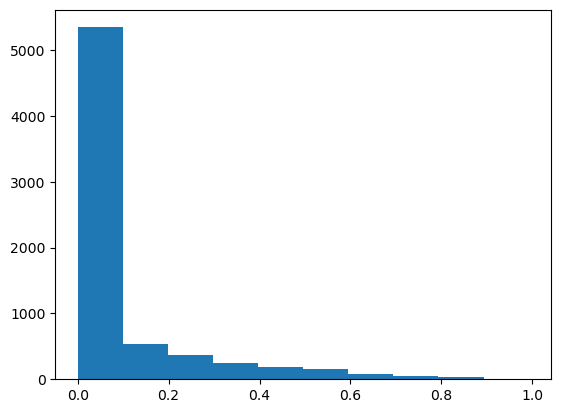

In [44]:
from matplotlib import pyplot as plt

n_total = 10000
n_train = int(n_total * 0.70)
n_test  = int(n_total * 0.15)
n_valid = int(n_total * 0.15)
batch_size = 64

ds_train = ds_proc.take(n_train).shuffle(100).batch(batch_size)
ds_test  = ds_proc.skip(n_train).take(n_test).shuffle(100).batch(batch_size)
ds_valid = ds_proc.skip(n_train+n_test).take(n_valid).shuffle(100).batch(batch_size)

# Check distribution of response in training data
y_train = y_test = [[ex[1]["pct_mortality"].numpy() for ex in ds_train]]
y_train = np.concatenate(y_train[0]).squeeze()

plt.hist(y_train)
plt.show()

### Model training

In [48]:
# Reset weights
model = build_preisler_model()

model.compile(
    loss=keras.losses.MeanSquaredLogarithmicError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    weighted_metrics=[keras.metrics.RootMeanSquaredError()]
)

In [49]:
earlystop = keras.callbacks.EarlyStopping(monitor="loss", patience=3)
checkpoint = keras.callbacks.ModelCheckpoint("tmp/preisler_model.keras")

history = model.fit(
    x=ds_train,
    validation_data=ds_valid,
    epochs=1,
    verbose=1,
    callbacks=[earlystop, checkpoint]
)

110/110 [==============================] - 7s 39ms/step - loss: 0.0410 - root_mean_squared_error: 0.2409 - val_loss: 0.0037 - val_root_mean_squared_error: 0.2881


### Show fit on training data

110/110 [==============================] - 3s 6ms/step


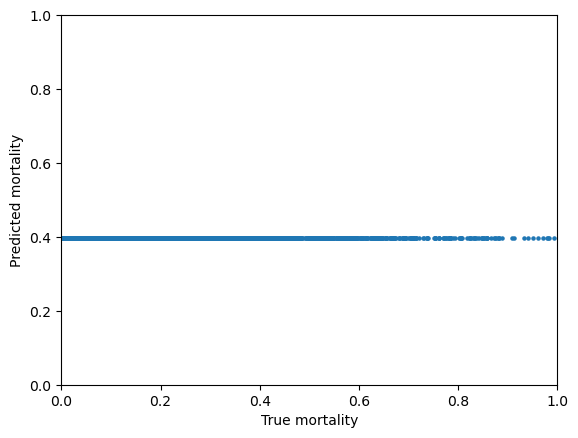

In [52]:
y_train_hat = model.predict(ds_train)
plt.scatter(y_train, y_train_hat, s=5)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xlabel("True mortality")
plt.ylabel("Predicted mortality")
plt.show()

### Evaluate on new data

In [16]:
import numpy as np
y_test = [[ex[1]["pct_mortality"].numpy() for ex in ds_test]]
y_test = np.concatenate(y_test[0]).squeeze()

In [17]:
y_pred = model.predict(ds_test)

469/469 [==============================] - 62s 16ms/step


In [20]:
# Check that the normalization layer is working right
norm_layer = model.layers[11]
my_tensor = tf.constant([0, 37.5, -121, 0.1, 2000, 2000, 2000, 2000, 1, -5])
my_tensor = my_tensor[tf.newaxis, :]

norm_layer(my_tensor, training=False)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.12334561, -4.8656235 ,  0.21250153,  0.3216189 ,  4.543332  ,
         2.4590585 ,  2.2418485 ,  1.0195467 ,  1.2524698 ,  0.29772353]],
      dtype=float32)>

In [27]:
min(y_pred)

array([0.02036094], dtype=float32)

In [28]:
max(y_pred)

array([0.02036095], dtype=float32)